In [44]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

from tensorflow.keras.layers import Embedding, Concatenate, Dense, Dropout, LSTM, Bidirectional, TextVectorization
from tensorflow.keras.models import Model

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [45]:
df = pd.read_csv('data/dataset.csv')
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [46]:
# Transformar dados de humor de texto em formato numérico (0 para não engraçado, 1 para engraçado)
le = LabelEncoder()
df['humor'] = le.fit_transform(df['humor'].astype(str))

In [47]:
# Separar dados de entrada e de saída
X = df['text'].values
y = df['humor'].values

In [48]:
# Calcular o tamanho médio das frases
sent_lens = [len(sentence.split()) for sentence in X]
avg_sent_lens = np.mean(sent_lens)

# Definir comprimento de saída máximo para a sequência
output_seq_length = int(np.percentile(sent_lens, 95))

# Criar vetorizador de texto para pré-processar dados de entrada
text_vectorizer = TextVectorization(output_sequence_length = output_seq_length)
text_vectorizer.adapt(X)

# Obter vocabulário de texto engraçado
humor_text_vocab = text_vectorizer.get_vocabulary()

In [49]:
# Definir camada de embedding para os tokens do texto
token_embed = Embedding(input_dim = len(humor_text_vocab), output_dim = 128, mask_zero = True)

In [50]:
# Separar os caracteres de cada frase
def split_chars(text):
    return " ".join(list(text))

xchars = [split_chars(sentence) for sentence in X]
alphabet = string.ascii_lowercase + string.digits + string.punctuation

# Calcular o tamanho médio de caracteres por frase
char_lens = [len(sentence) for sentence in X]
mean_char_len = np.mean(char_lens)

In [51]:
# Definir comprimento de saída máximo para a sequência de caracteres
output_seq_char_len = int(np.percentile(char_lens, 95))

In [52]:
# Criar vetorizador de caracteres para pré-processar dados de entrada
char_vectorizer = TextVectorization(output_sequence_length = output_seq_char_len, 
                                    standardize = 'lower_and_strip_punctuation')
char_vectorizer.adapt(xchars)

In [53]:
NUM_CHAR_TOKENS = len(alphabet) + 2 

# Definir camada de embedding para os caracteres
char_embed = Embedding(input_dim = NUM_CHAR_TOKENS, output_dim = 25, mask_zero = False)

In [54]:
# Criar uma camada de entrada para tokens (sequência de palavras)
token_inputs = layers.Input(shape=[], dtype=tf.string)
# Usar uma camada de pré-treinamento de embedding do TensorFlow Hub para criar embeddings (vetores numéricos) para cada token
# a partir dos inputs da camada anterior
token_embeddings = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")(token_inputs)
# Adicionar uma camada densa (totalmente conectada) para processar os embeddings de token e capturar relações entre eles
token_output = layers.Dense(128, activation = 'relu')(token_embeddings)
# Criar um modelo que vai receber a entrada dos tokens e gerar a saída processada pela camada densa
token_model = tf.keras.Model(token_inputs, token_output)

In [55]:
# Criar uma camada de entrada para caracteres
char_inputs = layers.Input(shape=(1,), dtype = tf.string, name = "char_input")
# Criar uma camada de vetorização dos caracteres, convertendo cada caractere em um valor numérico
char_vectors = layers.experimental.preprocessing.StringLookup(vocabulary = ['abcdefghijklmnopqrstuvwxyz'], 
                                                              mask_token=None)(char_inputs)

char_embeddings = layers.Embedding(input_dim = len('abcdefghijklmnopqrstuvwxyz') + 1, 
                                   output_dim = 25, mask_zero = True)(char_vectors)

char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
# Criar um modelo que recebe a entrada dos caracteres e gera a saída processada pelo embedding e pelo LSTM
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [56]:
# Juntar as saídas dos modelos de tokens e caracteres em uma única camada
token_char_concat = layers.Concatenate()([token_model.output, char_model.output])

In [57]:
# Adicionar camadas de Dropout para evitar overfitting do modelo
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(100, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.2)(combined_dense)

# Adicionar uma camada densa de saída com ativação sigmoid para classificação binária
output_layer = layers.Dense(1, activation = 'sigmoid')(final_dropout)

In [58]:
# Criar o modelo final, que recebe as entradas de tokens e caracteres e gera a saída processada pelas camadas criadas acima
model = tf.keras.Model([token_model.input, char_model.input], output_layer)
# Compilar o modelo com função de perda binária, otimizador Adam e métrica de acurácia
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [59]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((X, xchars))

train_char_token_labels = tf.data.Dataset.from_tensor_slices(y)

train_char_token_ds = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)).batch(32).prefetch(AUTOTUNE)

In [60]:
model_history = model.fit(train_char_token_ds, steps_per_epoch = int(len(train_char_token_ds) * 1), epochs = 7)

Epoch 1/5
6250/6250 [==============================] - 33s 4ms/step - loss: 0.2794 - accuracy: 0.8837
Epoch 2/5
6250/6250 [==============================] - 24s 4ms/step - loss: 0.2489 - accuracy: 0.8983
Epoch 3/5
6250/6250 [==============================] - 24s 4ms/step - loss: 0.2384 - accuracy: 0.9029
Epoch 4/5
6250/6250 [==============================] - 24s 4ms/step - loss: 0.2341 - accuracy: 0.9054
Epoch 5/5
6250/6250 [==============================] - 24s 4ms/step - loss: 0.2287 - accuracy: 0.9073


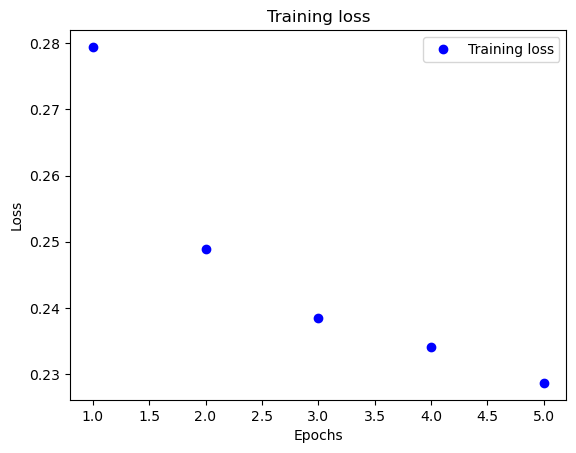

In [61]:
loss = model_history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()